<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/4Neural_Network_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time

df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')
for i in range(df.shape[0]):
  if(df.iloc[i]['y'] == 99999):
    df.loc[i, 'y'] = 4510

print(df.shape[0])
print(df['y'].max())
shuffled = df.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']

8750
4510.0


In [2]:
X_modified = X.drop([ 'median','max', 'k', 'min', 'range',  'indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n','m'], axis = 1)
print(X_modified.head())
#X_modified = X.drop(['max', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', '(m/n)^2', '(m/n)^3', 'class', 'av.length'], axis = 1)

     n   n/m   av.length     std.dev
0  120   2.5   60.358334   25.210638
1  200   5.0  100.695000   18.155994
2  220  11.0  891.086365  216.870728
3  120   2.5  101.750000   20.510399
4  100   2.5  103.150002   21.509867


In [3]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
tmp = tmp.sample(frac = 1).reset_index()
#y = np.log10(tmp['y']*10)+20
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)


1655304
1655304


In [4]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 4510*1/(1+K.exp(-x))

def custom_mse(y_true, y_pred):
  loss = K.square(tf.cast(y_pred, tf.float32) - tf.cast(y_true, tf.float32))  # (batch_size, 2)
  
  vec = []
  for i in range(128):
    if(y_true[i]<10):
      vec.append(100.0)
    elif(y_true[i]>=10 and y_true[i]<100):
      vec.append(50.0)
    elif(y_true[i]>=100 and y_true[i]<1000):
      vec.append(1.0)
    else:
      vec.append(1.0)
  
    # multiplying the values with weights along batch dimension
  vec = np.array(vec)
  loss = loss * vec.transpose()       # (batch_size, 2)
                
  loss = K.sum(loss, axis=1)        # (batch_size,)
    
  return loss

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    #classifier.add(Dense(32, activation = 'relu'))
    #classifier.add(Dense(32, activation = 'relu'))
    #classifier.add(Dense(16, activation = 'relu'))

    #model.add(Dense(32, activation='relu'))

    #model.add(Dense(64, activation='relu'))

    #model.add(Dense(8, activation='relu'))
    
    model.add(Dense(1, activation = 'relu'))
    #model.add(Activation(custom_activation, name='SpecialActivation'))
    #model.compile(loss='mean_squared_error', optimizer=tensorflow.keras.optimizers.Adam(clipnorm=1))
    #model.compile(loss='mean_squared_error', optimizer='RMSProp')
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [5]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=20, batch_size=128, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/20
10734/10734 [==============================] - 30s 3ms/step - loss: 212408.8594
Epoch 2/20
10734/10734 [==============================] - 18s 2ms/step - loss: 32438.5938
Epoch 3/20
10734/10734 [==============================] - 19s 2ms/step - loss: 30812.6367
Epoch 4/20
10734/10734 [==============================] - 18s 2ms/step - loss: 29103.6973
Epoch 5/20
10734/10734 [==============================] - 21s 2ms/step - loss: 28162.5391
Epoch 6/20
10734/10734 [==============================] - 19s 2ms/step - loss: 27581.1914
Epoch 7/20
10734/10734 [==============================] - 18s 2ms/step - loss: 27018.3672
Epoch 8/20
10734/10734 [==============================] - 18s 2ms/step - loss: 26489.0078
Epoch 9/20
10734/10734 [==============================] - 18s 2ms/step - loss: 26075.3887
Epoch 10/20
10734/10734 [==============================] - 18s 2ms/step - loss: 25553.3379
Epoch 11/20
10734/10734 [==============================] - 18s 2ms/step - loss: 24942.6914
Epoch 1

In [6]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd)) 

2199/2199 [==============================] - 3s 1ms/step
r_square score:  0.9941858141170221
RMSE:


80.93947963339431

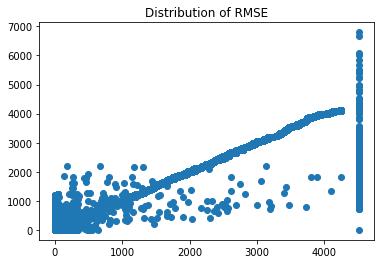

In [7]:
plt.title('Distribution of RMSE')

plt.scatter(yy, predd)

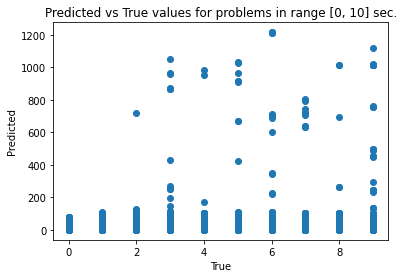

In [8]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]<10):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.title('Predicted vs True values for problems in range [0, 10] sec.')
plt.xlabel('True')
plt.ylabel('Predicted')

plt.scatter(yy_temp, predd_temp)
#plt.ylim([0, 100])

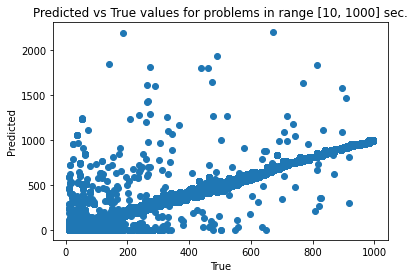

In [14]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]>=10 and yy[i]<1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.title('Predicted vs True values for problems in range [10, 1000] sec.')
plt.xlabel('True')
plt.ylabel('Predicted')

plt.scatter(yy_temp, predd_temp)

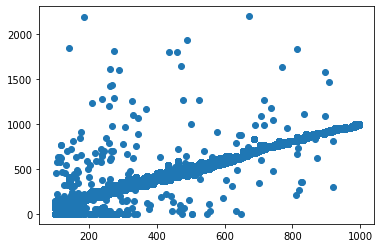

In [10]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]>=100 and yy[i]<1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.scatter(yy_temp, predd_temp)

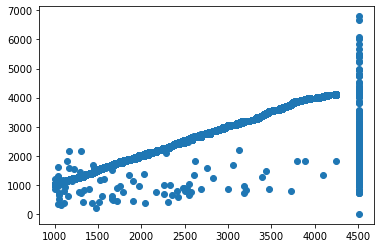

In [11]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]>=1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.scatter(yy_temp, predd_temp)